# Regression Project: Estimating Home Value

###### Chad Allen
###### 15 June 2021

## Project Description

The Zillow Data Science team wants to be able to predict the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August, 2017.

Additionally, information is needed outside of the model. Because property taxes are assessed at the county level, the team would like to know:

- What states and counties these are located in?
- What is the distribution of tax rates for each county?

## Goals

- Identify the drivers(features) for predicting the property values using the appraised value.
- Document the process and analysis through the data science pipeline.
- Construct a regression model for predicting home values that will do better than a baseline model.

## Deliverables

- Presentation with slides that summarizes finding about the drivers of property value.
- Jupyter Notebook report detailing the process through the pipeline.
- Acquire and Prepare files for recreating the process.
- README file that documents the project planning with instructions on how to recreate.

## Project Planning

What is the definition of a single unit property?
- "A housing unit is a single unit within a larger structure that can be used by an individual or household to eat, sleep, and live. The unit can be in any type of residence, such as a house, apartment, or mobile home, and may also be a single unit in a group of rooms." -www.investopedia.com
- For the purposes of this project, decided to use properties described as Residential General(260), Single Family Residential(261), Rural Residence(262), Mobile Home(263), and Townhouse(264) from the Zillow database.
- Using the above codes and the dates specified produced 28,185 records for initial analysis.


What features are the best for predicting a property's value?
- Initial focus on number of bathrooms, number of bedrooms, square feet and age.


What are the counties and tax rates for the transactions in the project?
- Use the FIPS code provide in the Zillow database to determine the counties included in the project.
- The Federal Information Processing Standard Publication 6-4 is a five-digit Federal Information Processing Standards code which uniquely identified counties and county equivalents in the United States, certain U.S. possessions, and certain freely associated states.

### Imports

In [1]:
import math
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns

import acquire
import prepare

import warnings
warnings.filterwarnings("ignore")

## Acquire

In [2]:
# use imported function to acquire the data, then take a quick look at columns and values
df = acquire.get_zillow_data()
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,yearbuilt,taxvaluedollarcnt,taxamount
0,11721753,2.0,3.0,1316.0,6037.0,1923.0,205123.0,2627.48
1,11289917,2.0,3.0,1458.0,6037.0,1970.0,136104.0,2319.90
2,11705026,1.0,2.0,1421.0,6037.0,1911.0,35606.0,543.69
3,14269464,3.0,4.0,2541.0,6059.0,2003.0,880456.0,9819.72
4,11446756,2.0,3.0,1491.0,6037.0,1955.0,107110.0,1399.27


In [3]:
df.shape

(28185, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28185 entries, 0 to 28184
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28185 non-null  int64  
 1   bathroomcnt                   28185 non-null  float64
 2   bedroomcnt                    28185 non-null  float64
 3   calculatedfinishedsquarefeet  28117 non-null  float64
 4   fips                          28185 non-null  float64
 5   yearbuilt                     28093 non-null  float64
 6   taxvaluedollarcnt             28184 non-null  float64
 7   taxamount                     28184 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.9 MB


In [5]:
df.describe()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,yearbuilt,taxvaluedollarcnt,taxamount
count,2.818500e+04,28185.000000,28185.000000,28117.000000,28185.000000,28093.000000,2.818400e+04,28184.000000
mean,1.304103e+07,2.314866,3.307007,1935.099655,6049.518148,1963.803973,5.353762e+05,6513.591189
std,3.744921e+06,1.019092,0.950045,995.910743,21.310960,23.124453,7.086644e+05,8234.312079
min,1.071186e+07,0.000000,0.000000,240.000000,6037.000000,1878.000000,1.000000e+03,51.260000
25%,1.151082e+07,2.000000,3.000000,1278.000000,6037.000000,1950.000000,1.986108e+05,2703.082500
50%,1.259386e+07,2.000000,3.000000,1675.000000,6037.000000,1961.000000,3.824460e+05,4734.900000
75%,1.414899e+07,3.000000,4.000000,2326.000000,6059.000000,1979.000000,6.327165e+05,7529.305000
max,1.676878e+08,11.000000,12.000000,17245.000000,6111.000000,2016.000000,2.385837e+07,276797.830000


#### Acquire Takeaways

- wrote a SQL query that joined tables to acquire the data from the database
- create and store a csv file to make it quicker for future use
- initial records = 28,185
- small proportion of missing and/or null values
- all numeric columns, some not needed for statistical analysis

## Prepare

In [6]:
# check for missing and dulicate values
prepare.miss_dup_values(df)

Your selected dataframe has 8 columns.
There are 4 columns that have missing values.
  
** There are 25 duplicate rows that represents 0.09% of total Values**


,Missing Values,% of Total Values
yearbuilt,92,0.3
calculatedfinishedsquarefeet,68,0.2
taxvaluedollarcnt,1,0.0
taxamount,1,0.0


In [7]:
# use imported function to prepare the data, then look at a sample
df = prepare.wrangle_zillow(df)
df.head()

,bathrooms,bedrooms,square_feet,county_code,age,appraised_value,taxes
parcelid,,,,,,,
11721753,2,3,1316,6037,94,205123,2627.48
11289917,2,3,1458,6037,47,136104,2319.90
11705026,1,2,1421,6037,106,35606,543.69
14269464,3,4,2541,6059,14,880456,9819.72
11446756,2,3,1491,6037,62,107110,1399.27


In [8]:
# final check for missing and dulicate values
prepare.miss_dup_values(df)

Your selected dataframe has 7 columns.
There are 0 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values


In [9]:
# look after cleaning
df.head()

,bathrooms,bedrooms,square_feet,county_code,age,appraised_value,taxes
parcelid,,,,,,,
11721753,2,3,1316,6037,94,205123,2627.48
11289917,2,3,1458,6037,47,136104,2319.90
11705026,1,2,1421,6037,106,35606,543.69
14269464,3,4,2541,6059,14,880456,9819.72
11446756,2,3,1491,6037,62,107110,1399.27


In [10]:
df.shape

(24888, 7)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24888 entries, 11721753 to 10713993
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        24888 non-null  int64  
 1   bedrooms         24888 non-null  int64  
 2   square_feet      24888 non-null  int64  
 3   county_code      24888 non-null  int64  
 4   age              24888 non-null  int64  
 5   appraised_value  24888 non-null  int64  
 6   taxes            24888 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 1.5 MB


In [12]:
# stats review of prepped data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,24888.0,2.087673,0.738494,1.00,2.0,2.000,3.00,4.00
bedrooms,24888.0,3.237946,0.795346,2.00,3.0,3.000,4.00,5.00
square_feet,24888.0,1745.419037,647.848329,326.00,1255.0,1603.000,2120.25,3890.00
county_code,24888.0,6049.674381,21.549776,6037.00,6037.0,6037.000,6059.00,6111.00
age,24888.0,54.066096,22.022301,1.00,40.0,57.000,67.00,139.00
appraised_value,24888.0,389087.826864,257280.338864,1000.00,181653.5,349048.000,543688.25,1183261.00
taxes,24888.0,4828.814468,3007.225892,51.26,2517.5,4370.505,6532.19,24366.44


#### Wrangle Takeaways

- set index to parcel_id
- removed duplicates and nulls
- renamed columns
- created age column (2017 - yearbuilt)
- removed outliers from bathrooms, bedroom, square_feet, and appraised_value (using IQR method)
- reduced records down to 24,888 (removed 3297 records total from intial dataset)

In [13]:
# drop columns not needed for project goals
mvp_df = df.drop(columns=['county_code', 'taxes'])
mvp_df.head()

,bathrooms,bedrooms,square_feet,age,appraised_value
parcelid,,,,,
11721753,2,3,1316,94,205123
11289917,2,3,1458,47,136104
11705026,1,2,1421,106,35606
14269464,3,4,2541,14,880456
11446756,2,3,1491,62,107110


In [14]:
# split the dataframe for analysis and testing
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_zillow(mvp_df, 'appraised_value')
train.shape, validate.shape, test.shape

((13937, 5), (5973, 5), (4978, 5))

In [15]:
# scale the data for modeling
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = prepare.Min_Max_Scaler(X_train, X_validate, X_test)
X_train_scaled.head()

,bathrooms,bedrooms,square_feet,age
parcelid,,,,
12071196,0.333333,0.333333,0.337262,0.651852
14274491,0.333333,0.333333,0.245230,0.437037
12825849,0.333333,0.333333,0.249719,0.444444
12445221,0.666667,0.333333,0.549663,0.192593
17146152,0.666667,0.666667,0.607744,0.088889


## Explore

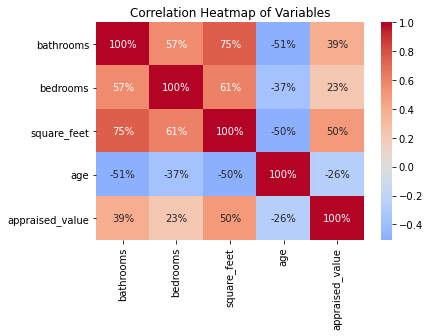

In [16]:
# create heatmap to examine correlations
sns.heatmap(train.corr(), cmap='coolwarm', center=0, annot=True, fmt='.0%')
plt.title('Correlation Heatmap of Variables')
plt.show()

In [17]:
def plot_variable_pairs(train):
    '''
    This function will accept a dataframe as input 
    and plot all the pairwise relationships with the regression line for each pair
    '''
    sns.pairplot(train, kind = 'reg', corner=True,
                plot_kws = {'line_kws': {'color': 'crimson'}})

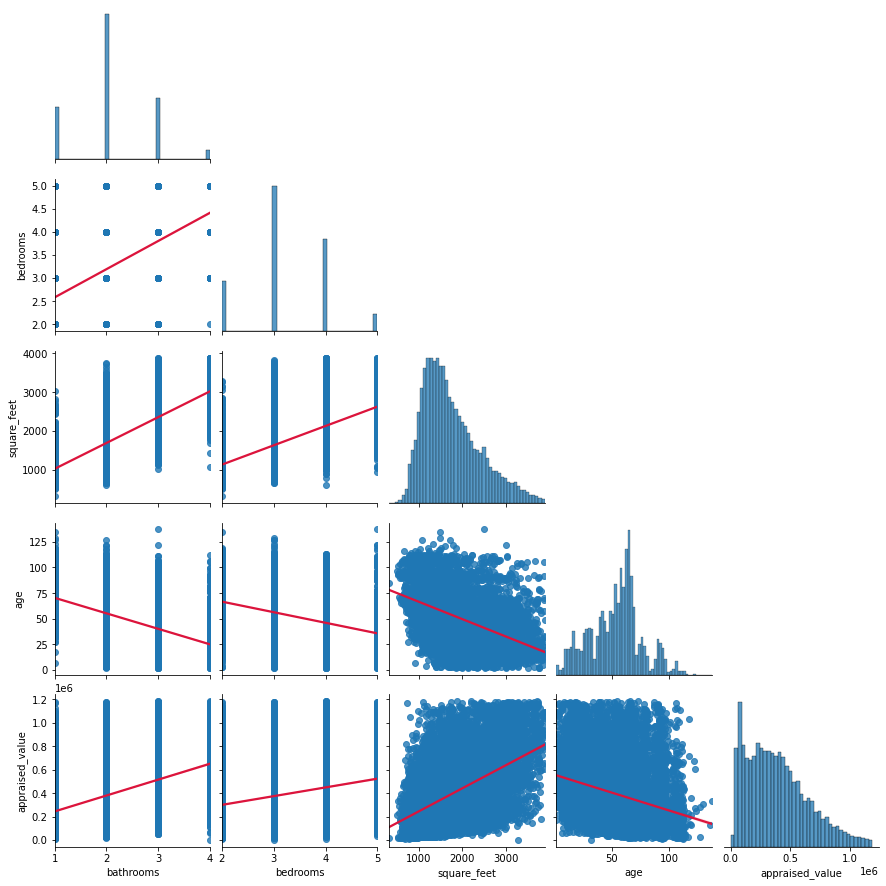

In [18]:
# visualization of pairwise realtionships
plot_variable_pairs(train)

#### Visualizations Takeaways

- significant positive correlation between appraised value and square feet
- strong positive correlation between appraised value and number of bathrooms
- negative correlation between appraised value and age


- will move ahead and do statistical testing on square feet and number of bathrooms

### Statistical Testing

#### T-Test: Does the square footage of the property affect the appraised value?

- The heatmap shows this category has the highest positive correlation.
- The median value of square_feet is ~1600 sq.ft.

Form hypothesis:

- $H_0$ The average appraised value of properties with 1600 sq.ft. or more is equal to the average appraised value of properties with 1600 sq.ft or less.
- $H_a$ The average appraised value of properties with 1600 sq.ft. or more is higher than the average appraised value of properties with 1600 sq.ft or less.

In [19]:
# set up groups for testing
sqft_less_than_1600 = train[train.square_feet <= 1600]
sqft_more_than_1600 = train[train.square_feet > 1600]

# perform 2 sample, 2-tailed t-test
t, p = stats.ttest_ind(sqft_more_than_1600.appraised_value, sqft_less_than_1600.appraised_value)
print(t, p)

# set alpha
alpha = 0.05

null_hypothesis = "the average appraised value of properties with 1600 sq.ft. or more is equal to the average appraised value of properties with 1600 sq.ft or less."

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')

48.50374026487064 0.0

We can reject the null hypothesis that the average appraised value of properties with 1600 sq.ft. or more is equal to the average appraised value of properties with 1600 sq.ft or less.


#### Correlation Test: Does the number of bathrooms affect the appraised value?

- The heatmap shows this category has a strong positive correlation.

Form hypothesis:

- $H_0$ The number of bathrooms has no affect on the appraised value (independent)
- $H_a$ The number of bathrooms does have an affect on appraised value (dependent)

In [20]:
# perform Pearson's r test
corr, p = stats.pearsonr(train.bathrooms, train.appraised_value)
print(corr, p)

# set alpha
alpha = 0.05

null_hypothesis = "the number of the bathrooms has no affect on the appraised value."

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')

0.38868892326661064 0.0

We can reject the null hypothesis that the number of the bathrooms has no affect on the appraised value.


#### Testing Takeaways

- rejected both null hypotheses based on the test results
- there is evidence to support that there the average appraised value of properties with 1600 sq.ft. or more is higher than the average appraised value of properties with 1600 sq.ft or less
- there is evidence to support that the number of bathrooms does have an affect on appraised value

## Modeling

#### Establish a baseline

In [21]:
# create dataframe for target results
y_train = pd.DataFrame({'actual': y_train})
y_validate = pd.DataFrame({'actual': y_validate})

# create baseline using mean and add to dataframe
y_train['baseline'] = y_train.actual.mean()
y_validate['baseline'] = y_train.actual.mean()

print('Train RMSE Baseline model:', math.sqrt(mean_squared_error(y_train.actual, y_train.baseline)))
rmse_baseline = math.sqrt(mean_squared_error(y_validate.actual, y_validate.baseline))
print('Validate RMSE baseline:', rmse_baseline)

Train RMSE Baseline model: 258931.76560414536
Validate RMSE baseline: 253998.06691963325


#### Model1 - OLS (LinearRegression)

In [22]:
# create the model
ols = LinearRegression(normalize=True)
# fit the model
ols.fit(X_train_scaled, y_train.actual)
# use the model to make predictions
y_train['ols'] = ols.predict(X_train_scaled)
y_validate['ols'] = ols.predict(X_validate_scaled)

print('Train RMSE for OLS model:', math.sqrt(mean_squared_error(y_train.actual, y_train.ols)))
rmse_ols = math.sqrt(mean_squared_error(y_validate.actual, y_validate.ols))
print('Validate RMSE for OLS model:', rmse_ols)
print('r^2_validate for OLS model:', explained_variance_score(y_validate.actual, y_validate.ols))

Train RMSE for OLS model: 223063.17208168618
Validate RMSE for OLS model: 223095.65294493307
r^2_validate for OLS model: 0.22793573582264615


#### Model2 - LassoLars

In [23]:
# create the model
lars = LassoLars(alpha=1)
# fit the model
lars.fit(X_train_scaled, y_train.actual)
# use the model to make predictions
y_train['lars'] = lars.predict(X_train_scaled)
y_validate['lars'] = lars.predict(X_validate_scaled)

print('Train RMSE for LassoLars(alpha=1):', math.sqrt(mean_squared_error(y_train.actual, y_train.lars)))
rmse_lars = math.sqrt(mean_squared_error(y_validate.actual, y_validate.lars))
print('Validate RMSE for LassoLars(alpha=1):', rmse_lars)
print('r^2_validate for LassoLars(alpha=1):', explained_variance_score(y_validate.actual, y_validate.lars))

Train RMSE for LassoLars(alpha=1): 223063.36376190305
Validate RMSE for LassoLars(alpha=1): 223080.17974962742
r^2_validate for LassoLars(alpha=1): 0.22804274181088158


#### Model3 - TweedieRegressor (GLM)

In [24]:
# create the model
glm = TweedieRegressor(power=1, alpha=0)
# fit the model
glm.fit(X_train_scaled, y_train.actual)
# use the model to make predictions
y_train['glm'] = glm.predict(X_train_scaled)
y_validate['glm'] = glm.predict(X_validate_scaled)

print('Train RMSE for TweedieRegressor(power=1, alpha=0):', math.sqrt(mean_squared_error(y_train.actual, y_train.glm)))
rmse_model3 = math.sqrt(mean_squared_error(y_validate.actual, y_validate.glm))
print('Validate RMSE for TweedieRegressor(power=1, alpha=0):', rmse_model3)
print('r^2_validate for TweedieRegressor(power=1, alpha=0):', explained_variance_score(y_validate.actual, y_validate.glm))

Train RMSE for TweedieRegressor(power=1, alpha=0): 223414.93675605417
Validate RMSE for TweedieRegressor(power=1, alpha=0): 223579.1858048459
r^2_validate for TweedieRegressor(power=1, alpha=0): 0.22460656373665178


#### Modeling Takeaways

- all models performed better than the baseline
- OLS and LassoLars results were very close, but LassoLars had a better r^2 result
- will use LassoLars on test data

## Best Model

#### LassoLars

In [25]:
# create dataframe
y_test = pd.DataFrame({'actual': y_test})
# use the model to make predictions
y_test['lars'] = lars.predict(X_test_scaled)

print('Train RMSE for LassoLars(alpha=1):', math.sqrt(mean_squared_error(y_train.actual, y_train.lars)))
print('r^2_train for LassoLars(alpha=1):', explained_variance_score(y_train.actual, y_train.lars))
print('Validate RMSE for LassoLars(alpha=1):', rmse_lars)
print('r^2_validate for LassoLars(alpha=1):', explained_variance_score(y_validate.actual, y_validate.lars))
print('Test RMSE for for LassoLars(alpha=1):', math.sqrt(mean_squared_error(y_test.actual, y_test.lars)))
print('r^2_test for for LassoLars(alpha=1):', explained_variance_score(y_test.actual, y_test.lars))

Train RMSE for LassoLars(alpha=1): 223063.36376190305
r^2_train for LassoLars(alpha=1): 0.25786001931172553
Validate RMSE for LassoLars(alpha=1): 223080.17974962742
r^2_validate for LassoLars(alpha=1): 0.22804274181088158
Test RMSE for for LassoLars(alpha=1): 226542.74556106445
r^2_test for for LassoLars(alpha=1): 0.22001885821228218


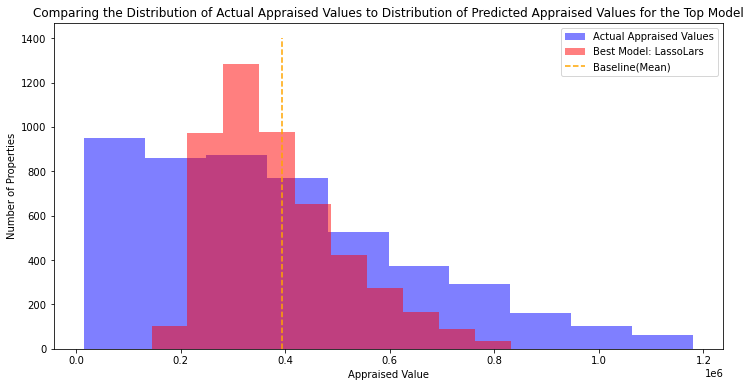

In [26]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(12,6))
plt.hist(y_test.actual, color='blue', alpha=.5, label="Actual Appraised Values")
plt.vlines(y_train.actual.mean(), 0, 1400, ls='--', color='orange', label='Baseline(Mean)')
plt.hist(y_test.lars, color='red', alpha=.5, label='Best Model: LassoLars')
plt.xlabel("Appraised Value")
plt.ylabel("Number of Properties")
plt.title("Comparing the Distribution of Actual Appraised Values to Distribution of Predicted Appraised Values for the Top Model")
plt.legend()
plt.show()

### Conclusions 

- used number of bathrooms, number of bedrooms, square feet and age as predictors of appraised value
- slight changes in RMSE from train to validate to test means model is not overfit
- slight decline in r^2 score from validate to test means only slight decrease in accuracy
- best model test results beat the baseline by ~22.0%

#### Next Steps 
- possible ways to improve the results:
- - adding/changing features 
- - tweaking hyperparameters

## Additional Deliverables

#### What are the counties and tax rates for the transactions in the project?

What states and counties these are located in?
- looked up FIPS codes for transactions included in the research for this project
- - 6037 - Los Angeles County, California
- - 6059 - Orange County, California
- - 6111 - Ventura County, California

In [27]:
# add the name of the county based on the FIPS numbers from the db
df['county_name'] = df['county_code'].map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})

# show counts by county
county_counts = pd.DataFrame(df.county_name.value_counts())
county_counts

,county_name
Los Angeles,15842
Orange,6807
Ventura,2239


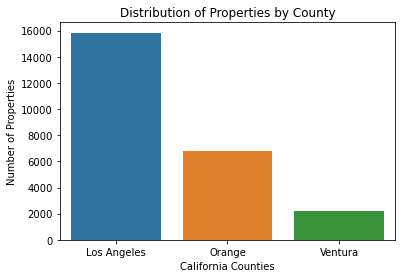

In [28]:
# quick viz of properties by county
plt.title('Distribution of Properties by County')
sns.countplot(df.county_name)
plt.xlabel('California Counties')
plt.ylabel('Number of Properties')
plt.show()

What is the distribution of tax rates for each county?

In [29]:
# Calculate the tax rate and add it as a column
df['tax_rate'] = (df['taxes'] / df['appraised_value'])

print(df.groupby('county_name').tax_rate.mean())

county_name
Los Angeles    0.014252
Orange         0.012151
Ventura        0.011876
Name: tax_rate, dtype: float64


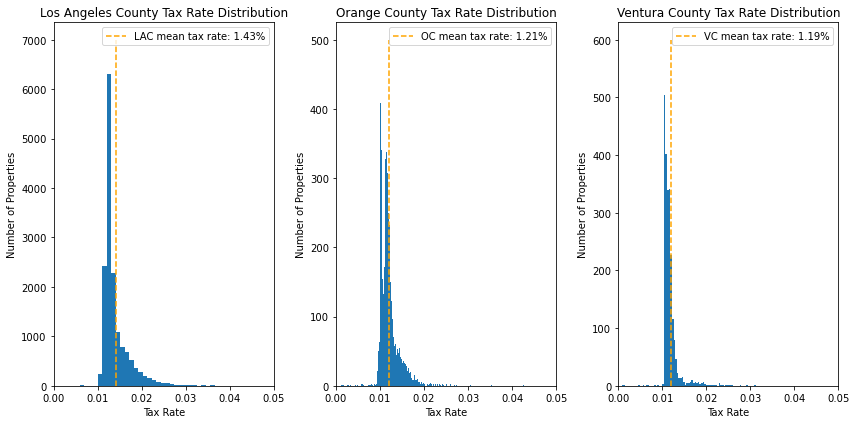

In [30]:
# visualization showing side-by-side comparison of county tax rate

plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.title('Los Angeles County Tax Rate Distribution')
plt.hist(df[df.county_code==6037].tax_rate, bins=800)
plt.vlines(df[df.county_code==6037].tax_rate.mean(), 0, 7000, ls='--', color='orange', label='LAC mean tax rate: 1.43%')
plt.xlabel('Tax Rate')
plt.ylabel('Number of Properties')
plt.legend()
plt.xlim(0.0, 0.05)

plt.subplot(1,3,2)
plt.title('Orange County Tax Rate Distribution')
plt.hist(df[df.county_code==6059].tax_rate, bins=800)
plt.vlines(df[df.county_code==6059].tax_rate.mean(), 0, 500, ls='--', color='orange', label='OC mean tax rate: 1.22%')
plt.xlabel('Tax Rate')
plt.ylabel('Number of Properties')
plt.xlim(0.0, 0.05)

plt.legend()

plt.subplot(1,3,3)
plt.title('Ventura County Tax Rate Distribution')
plt.hist(df[df.county_code==6111].tax_rate, bins=800)
plt.vlines(df[df.county_code==6111].tax_rate.mean(), 0, 600, ls='--', color='orange', label='VC mean tax rate: 1.19%')
plt.xlabel('Tax Rate')
plt.ylabel('Number of Properties')
plt.xlim(0.0, 0.05)
plt.legend()

plt.tight_layout()

plt.show()